In [1]:
import os
from typing import Dict, Union, Tuple, List, Any
from PIL import Image
import numpy as np
import pandas as pd
import torch
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from torch import nn
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MFConv
import torch.nn.functional as F
from rdkit.Chem.rdchem import ChiralType, HybridizationType
from tqdm import tqdm

# 0 Read the molecule

In [2]:
def get_smiles_list(smiles_file):
    mols = Chem.SDMolSupplier(smiles_file)
    # Make sure that all molecules are not empty
    mols = [mol for mol in mols if mol is not None]
    return mols

# 1 Obtain molecular information

## 1.1 Get the molecular tag

In [3]:
def get_mol_label(mol):
    atom_indices = [atom.GetIdx() for atom in mol.GetAtoms()]
    for index__, idx_ in enumerate(atom_indices):
        mol.GetAtomWithIdx(idx_).SetProp('molAtomMapNumber', str(index__ + 1))
    return mol


def get_atom_list(mol) -> Any:
    atom_list = []
    bonds_list = []
    for atom in mol.GetAtoms():
        atom_dict = {
            'index': atom.GetIdx(),
            'Element_symbols': atom.GetSymbol(),
            'atomic_number': atom.GetAtomicNum(),
            'Price': atom.GetDegree(),
            'quality': atom.GetMass(),
        }
        atom_list.append(atom_dict)
    for bond in mol.GetBonds():
        bond_dict = {
            'index': bond.GetIdx(),
            'Start_atomic_index': bond.GetBeginAtomIdx(),
            'End_atomic_indexes': bond.GetEndAtomIdx(),
            'is_conjugated': bond.GetIsConjugated(),
            'is_ring': bond.IsInRing(),
            'type': bond.GetBondTypeAsDouble(),
        }
        bonds_list.append(bond_dict)
    return atom_list, bonds_list

## 1.2 Gets the atomic feature label

In [4]:
def get_x_traits_label():
    mol_label = [
        'ID',
        # Atom-type: 10
        'Atom-type(C): 0', 'Atom-type(N): 1',
        'Atom-type(O): 2', 'Atom-type(F): 3',
        'Atom-type(P): 4', 'Atom-type(S): 5',
        'Atom-type(Cl): 6', 'Atom-type(Br): 7',
        'Atom-type(I): 8', 'Atom-type(other): 9',

        # Atom-based: 16
        'Atom-based(is_implicitValence): 10', 'Atom-based(is_formalCharge): 11',
        'Atom-based(is_radicalElectrons): 12', 'Atom-based(is_aromatic): 13',
        'Atom-based(is_chirality[CCW]): 14', 'Atom-based(is_chirality[CW]): 15',
        'Atom-based(is_chirality[OTHER]): 16', 'Atom-based(is_chirality[UNSPECIFIED]): 17',
        'Atom-based(is_hybridization[S]): 18', 'Atom-based(is_hybridization[SP]): 19',
        'Atom-based(is_hybridization[SP2]): 20', 'Atom-based(is_hybridization[SP3]): 21',
        'Atom-based(is_hybridization[SP3D]): 22', 'Atom-based(is_hybridization[SP3D2]): 23',
        'Atom-based(is_hybridization[OTHER]): 24', 'Atom-based(is_hybridization[UNSPECIFIED]): 25',

        # Topol-based: 3
        'Topol-based(degree): 26', 'Topol-based(hydrogen): 27', 'Topol-based(ringStatus): 28'
    ]
    return mol_label

## 1.3 Obtain binding sites

In [5]:
def _get_labels(mol):
    _y = []
    som = ['PRIMARY_SOM_1A2', 'PRIMARY_SOM_2A6', 'PRIMARY_SOM_2B6', 'PRIMARY_SOM_2C8', 'PRIMARY_SOM_2C9',
           'PRIMARY_SOM_2C19', 'PRIMARY_SOM_2D6', 'PRIMARY_SOM_2E1', 'PRIMARY_SOM_3A4',
           'SECONDARY_SOM_1A2', 'SECONDARY_SOM_2A6', 'SECONDARY_SOM_2B6', 'SECONDARY_SOM_2C8', 'SECONDARY_SOM_2C9',
           'SECONDARY_SOM_2C19', 'SECONDARY_SOM_2D6', 'SECONDARY_SOM_2E1', 'SECONDARY_SOM_3A4',
           'TERTIARY_SOM_1A2', 'TERTIARY_SOM_2A6', 'TERTIARY_SOM_2B6', 'TERTIARY_SOM_2C8', 'TERTIARY_SOM_2C9',
           'TERTIARY_SOM_2C19', 'TERTIARY_SOM_2D6', 'TERTIARY_SOM_2E1', 'TERTIARY_SOM_3A4'
           ]
    result = []
    for k in som:
        try:
            _res = mol.GetProp(k)
            if ' ' in _res:
                res = _res.split(' ')
                for s in res:
                    result.append(int(s))
            else:
                result.append(int(_res))
        except KeyError:
            pass

    for data in result:
        _y.append(data)
    _y = list(set(_y))

    y = np.zeros(len(mol.GetAtoms()))
    for i in _y:
        y[i - 1] = 1
    return y

## 1.4 Get atomic features

In [6]:
def get_x_traits(mol):
    all_node_feats = []
    identity = {
        'C': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'N': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        'O': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        'F': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        'P': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        'S': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        'Cl': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        'Br': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        'I': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        'other': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    }
    for atom in mol.GetAtoms():
        node_feats = []
        # atom number
        idx = atom.GetIdx()

        # Atom-type
        # atom type one-hot 10
        node_feats.extend(identity.get(atom.GetSymbol(), [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))



        # Atom-based
        # implicit valence
        node_feats.append(atom.GetImplicitValence())
        # formal charge
        node_feats.append(atom.GetFormalCharge())
        # radical electrons
        node_feats.append(atom.GetNumRadicalElectrons())
        # aromatic 0 or 1
        if atom.GetIsAromatic():
            node_feats.append(1)
        else:
            node_feats.append(0)
        # chirality
        chirality = atom.GetChiralTag()
        temp = None
        if chirality == ChiralType.CHI_TETRAHEDRAL_CCW: temp = [1, 0, 0, 0]
        if chirality == ChiralType.CHI_TETRAHEDRAL_CW: temp = [0, 1, 0, 0]
        if chirality == ChiralType.CHI_OTHER: temp = [0, 0, 1, 0]
        if chirality == ChiralType.CHI_UNSPECIFIED: temp = [0, 0, 0, 1]
        node_feats.extend(temp)
        # hybridization
        hybridization = atom.GetHybridization()
        tmp = None
        if hybridization == HybridizationType.S: tmp = [1, 0, 0, 0, 0, 0, 0, 0]
        if hybridization == HybridizationType.SP: tmp = [0, 1, 0, 0, 0, 0, 0, 0]
        if hybridization == HybridizationType.SP2: tmp = [0, 0, 1, 0, 0, 0, 0, 0]
        if hybridization == HybridizationType.SP3: tmp = [0, 0, 0, 1, 0, 0, 0, 0]
        if hybridization == HybridizationType.SP3D: tmp = [0, 0, 0, 0, 1, 0, 0, 0]
        if hybridization == HybridizationType.SP3D2: tmp = [0, 0, 0, 0, 0, 1, 0, 0]
        if hybridization == HybridizationType.OTHER: tmp = [0, 0, 0, 0, 0, 0, 1, 0]
        if hybridization == HybridizationType.UNSPECIFIED: tmp = [0, 0, 0, 0, 0, 0, 0, 1]
        node_feats.extend(tmp)


        # Topol-based
        # degree
        node_feats.append(atom.GetDegree())
        # hydrogen
        node_feats.append(atom.GetTotalNumHs())
        # ring status 0 or 1
        if atom.IsInRing():
            node_feats.append(1)
        else:
            node_feats.append(0)
        # Append node features to matrix
        all_node_feats.append(node_feats)


    all_node_feats = np.asarray(all_node_feats, dtype=np.float64)
    return all_node_feats

## 1.5 Obtain molecular bond characteristics

In [7]:
def get_edges_and_attr(mol):
    edge_index = []
    edge_attr = []
    start_index = []
    end_index = []
    start_attr = []
    end_attr = []
    atomList, bondsList = get_atom_list(mol)
    for bond_ in bondsList:
        start_index.extend([atomList[bond_['Start_atomic_index']]['index'], atomList[bond_['End_atomic_indexes']]['index']])
        end_index.extend([atomList[bond_['End_atomic_indexes']]['index'], atomList[bond_['Start_atomic_index']]['index']])
        start_attr.extend([bond_['type'], bond_['type']])
        end_attr.extend([bond_['type'], bond_['type']])
        # star_ = [atomList[bond_['Start_atomic_index']]['quality'], atomList[bond_['End_atomic_indexes']]['quality']]
        # end_ = [atomList[bond_['End_atomic_indexes']]['quality'], atomList[bond_['Start_atomic_index']]['quality']]
    
    edge_index.append(start_index)
    edge_index.append(end_index)
    edge_attr.append(start_attr)
    edge_attr.append(end_attr)
    return edge_index, edge_attr

In [8]:
## 1.6 Obtain molecular image attributes

In [9]:
def get_mol_traits(index, name, mol):
    smiles = Chem.MolToSmiles(mol)
    x_traits = get_x_traits(mol)
    y_traits = _get_labels(mol)
    x_traits_label = get_x_traits_label()
    edge_index, edge_attr = get_edges_and_attr(mol)
    atom_list, _ = get_atom_list(mol)
    atom_labels = []
    for atom in atom_list:
        atom_labels.append(f"{atom['Element_symbols']}: {str(atom['index'])}")
    data = Data(
        index=index,
        name=name,
        smiles=smiles,
        x=torch.tensor(x_traits),
        y=torch.tensor(y_traits),
        edge_index=torch.tensor(edge_index),
        edge_attr=torch.tensor(edge_attr),
        x_traits_label=x_traits_label,
        atom_labels=atom_labels,
    )
    return data

# 2 Get a list of molecular data

## 2.1 Get a list of molecular objects

In [10]:
def get_mols_list(smiles_file):
    mols =  get_smiles_list(smiles_file)
    data_list = []
    # Iterate through each molecule in the SDF file
    for index, mol in enumerate(mols):
        # if mol is not None:
        name = mol.GetProp('ID') if mol.HasProp('ID') else 'Unknown'
        # Get the SMILES representation of the molecule
        data = get_mol_traits(index, name, mol)
        data_list.append(data)
    # return data_list
    return DataLoader(data_list, 1, shuffle=False)

## 2.2 Annotate the molecular subplot

In [11]:
def draw_molecule_with_colors(mol, atom_colors):
    drawer = rdMolDraw2D.MolDraw2DCairo(600, 600)  # Create a drawing object
    drawer.DrawMolecule(mol, highlightAtoms=list(atom_colors.keys()), highlightBonds=[], highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

# 2 Model manipulation

## 2.1 Training

In [12]:
class TrainModel(nn.Module):
    def __init__(self, args):
        super(TrainModel, self).__init__()
        num_classses = 2

        conv_hidden = args['conv_hidden']
        cls_hidden = args['cls_hidden']

        self.conv1 = MFConv(29, conv_hidden, 5)
        self.conv2 = MFConv(conv_hidden, conv_hidden, 5)
        self.conv3 = MFConv(conv_hidden, conv_hidden, 5)
        self.conv4 = MFConv(conv_hidden, conv_hidden, 5)

        self.linear1 = nn.Linear(conv_hidden, cls_hidden)
        self.linear2 = nn.Linear(cls_hidden, num_classses)
        self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(p=0.5)

    def forward(self, mol):
        res = self.conv1(mol.x, mol.edge_index)
        res = self.conv2(res, mol.edge_index)
        res_2 = res
        res = self.conv3(res, mol.edge_index)
        res_3 = res
        res = self.conv4(res, mol.edge_index)

        res = res + res_3 + res_2

        res = self.linear1(res)
        res = self.relu(res)
        res = self.drop1(res)
        res = self.linear2(res)
        return res

## 2.2 Explainability

In [13]:
class ExplainModel(torch.nn.Module):
    def __init__(self, args: dict):
        super(ExplainModel, self).__init__()
        num_features = args['num_features']
        num_classes = args['num_classes']
        self.conv1 = MFConv(num_features, num_classes)
        self.conv2 = MFConv(num_classes, num_classes)
        self.conv3 = MFConv(num_classes, num_classes)
        self.conv4 = MFConv(num_classes, num_classes)

    def forward(self, x, edge_index, edge_weight=None):
        # edge_index = edge_index.to(self.device)
        x1 = F.relu(self.conv1(x, edge_index))
        x1 = F.dropout(x1, training=self.training)
        x2 = F.relu(self.conv2(x1, edge_index))
        x2 = F.dropout(x2, training=self.training)
        x3 = F.relu(self.conv3(x2, edge_index))
        x3 = F.dropout(x3, training=self.training)
        x4 = self.conv4(x3, edge_index)
        return F.log_softmax(x4, dim=1)

# 3 Access parameter settings

## 3.1 Parameter settings

In [14]:
args_ = {
    'epoch': 200,
    'num_features': 29,
    'num_classes': 29,
    'conv_hidden': 1024,
    'cls_hidden': 1024,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
}
smilesFile = "../data/merged.sdf"

## 3.2 Parameter settings

In [15]:
saveMolImgDir = '../data/IM_picture'
saveDir = '../data/Molecular_tags'
if not os.path.exists(saveMolImgDir): os.mkdir(saveMolImgDir)
if not os.path.exists(saveDir): os.mkdir(saveDir)
AtomDataFrameFile = os.path.join(saveDir, 'keyAtom.csv')
TraitsDataFrameFile = os.path.join(saveDir, 'keyTraits.csv')

# 4 Extract the subgraph

In [16]:
dataList = get_mols_list(smilesFile)

keyAtomList = []
keyTraitsList = []
keyAtomDictList = pd.DataFrame(columns=['ID', 'KeyAtom'], index=[i for i in range(len(dataList))])

keyTraitsColumns = get_x_traits_label()
keyTraitsDictList = pd.DataFrame(
    columns=keyTraitsColumns, index=[i for i in range(len(dataList))])
if not os.path.exists(saveMolImgDir): os.mkdir(saveMolImgDir)

键类型: (1.0, 0)
键类型: (2.0, 1)
键类型: (1.0, 2)
键类型: (1.0, 2)
键类型: (1.0, 2)
键类型: (1.0, 2)
键类型: (1.0, 3)
键类型: (1.0, 4)
键类型: (2.0, 5)
键类型: (1.0, 5)
键类型: (1.0, 6)
键类型: (1.0, 7)
键类型: (2.0, 10)
键类型: (1.0, 12)
键类型: (1.0, 13)
键类型: (2.0, 13)
键类型: (1.0, 15)
键类型: (2.0, 16)
键类型: (1.0, 17)
键类型: (1.0, 18)
键类型: (2.0, 18)
键类型: (1.0, 20)
键类型: (1.0, 0)
键类型: (1.5, 1)
键类型: (1.5, 1)
键类型: (1.5, 2)
键类型: (1.5, 3)
键类型: (1.5, 4)
键类型: (1.0, 4)
键类型: (1.5, 5)
键类型: (1.0, 5)
键类型: (1.5, 0)
键类型: (1.5, 0)
键类型: (1.5, 0)
键类型: (1.5, 1)
键类型: (1.5, 1)
键类型: (1.5, 2)
键类型: (1.5, 2)
键类型: (1.5, 3)
键类型: (1.5, 3)
键类型: (1.5, 4)
键类型: (1.5, 4)
键类型: (1.5, 5)
键类型: (1.5, 5)
键类型: (1.5, 6)
键类型: (1.5, 7)
键类型: (1.5, 8)
键类型: (1.5, 9)
键类型: (1.0, 9)
键类型: (1.5, 11)
键类型: (1.5, 13)
键类型: (1.0, 16)
键类型: (2.0, 16)
键类型: (1.0, 0)
键类型: (1.0, 0)
键类型: (1.5, 1)
键类型: (1.5, 1)
键类型: (1.0, 2)
键类型: (2.0, 2)
键类型: (1.5, 5)
键类型: (1.5, 6)
键类型: (1.0, 6)
键类型: (1.5, 7)
键类型: (1.0, 7)
键类型: (1.5, 8)
键类型: (1.0, 10)
键类型: (1.5, 11)
键类型: (1.5, 11)
键类型: (1.5, 12)
键类型: (1.5, 13)
键

Data interpretable analysis:   0%|          | 0/680 [00:01<?, ?it/s]

KeyboardInterrupt



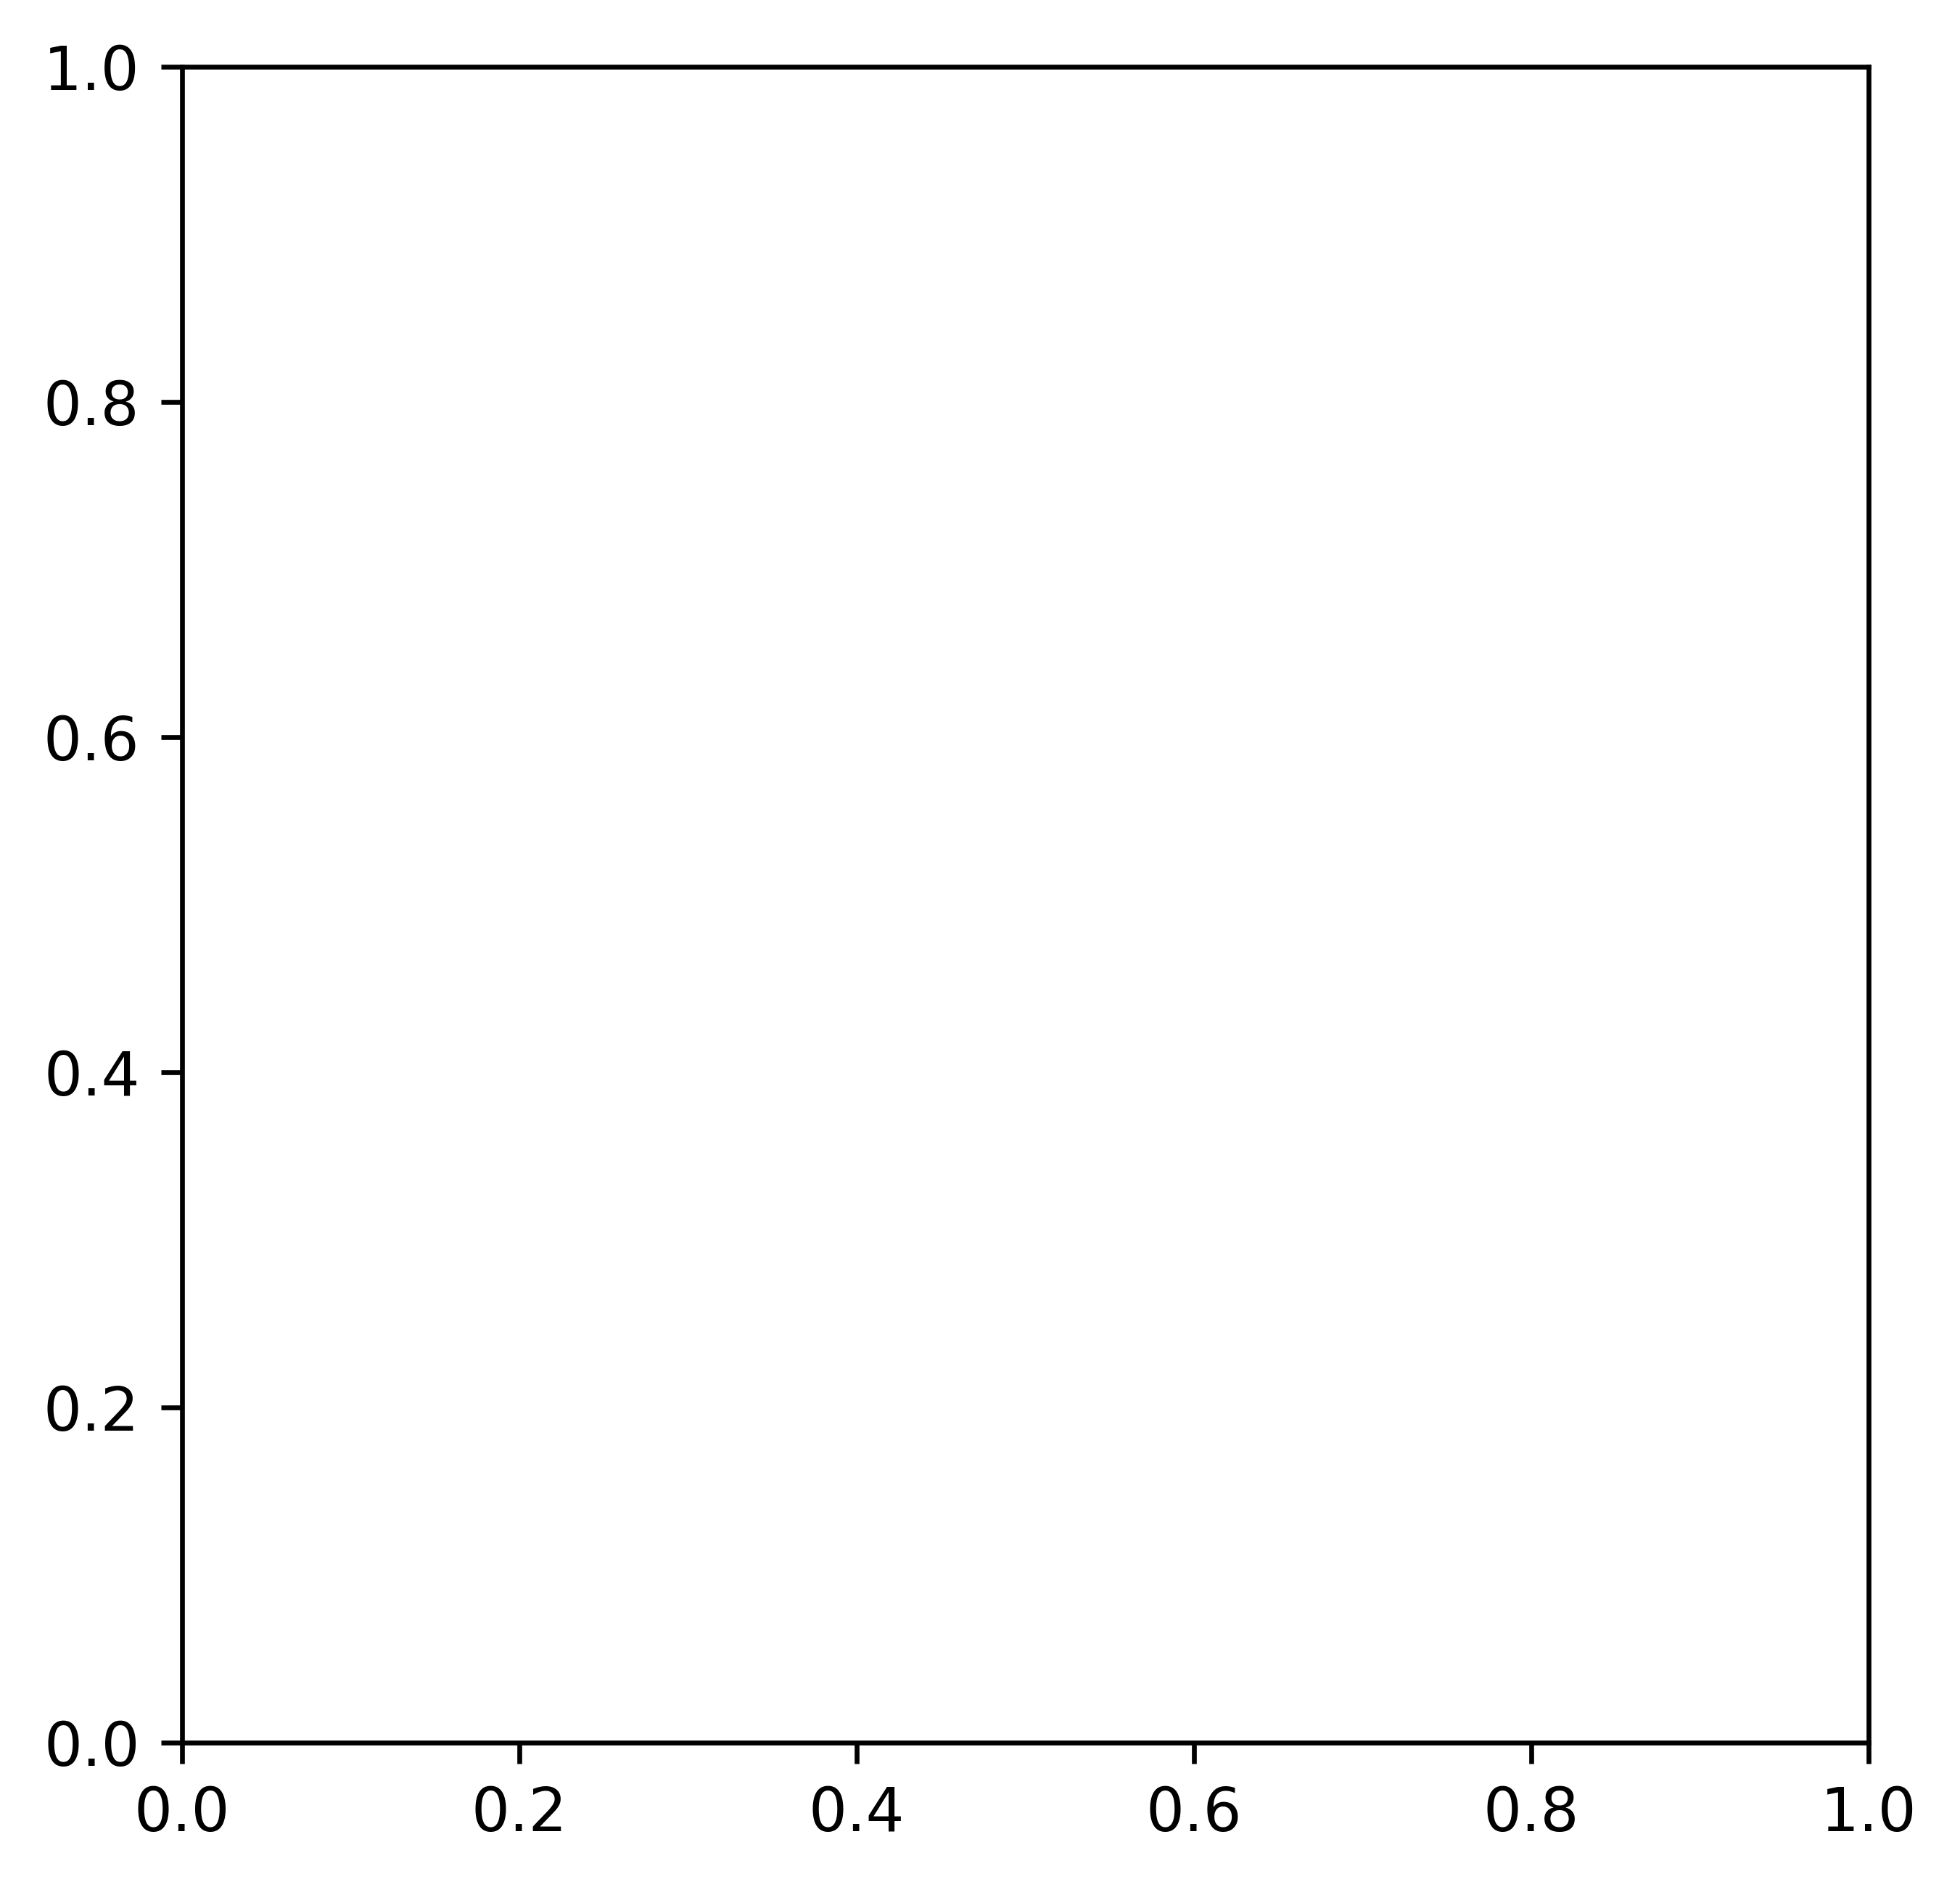

In [17]:
_index = 0
ax = [None]
fig, ax[0] = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), dpi=600)
for data_ in tqdm(dataList, total=len(dataList), desc='Data interpretable analysis'):
    # if _index < 672:
    #     _index += 1
    #     continue
    _data = data_.to(args_['device'])
    _x = None
    _edge_index = None
    trainOutput = None
    node_index = len(_data.atom_labels)
    sf = nn.Softmax(dim=1)
    trainModel = TrainModel(args_).to(args_['device'])
    explainModel = ExplainModel(args_).to(args_['device'])

    trainOptimizer = torch.optim.Adam(trainModel.parameters(), lr=0.01, weight_decay=5e-4)
    explainOptimizer = torch.optim.Adam(explainModel.parameters(), lr=0.01, weight_decay=5e-4)
    trainModel.train()
    explainModel.train()
    for epoch in range(1, args_['epoch'] + 1):
        mol_ = _data.to(args_['device'])
        mol_.x = mol_.x.to(torch.float32)
        _x = _data.x.to(torch.float)
        _edge_index = _data.edge_index.to(torch.long)

        trainOptimizer.zero_grad()
        trainOutput = trainModel(mol_)
        trainOptimizer.step()

        explainOptimizer.zero_grad()
        explainOutput = explainModel(_x, _edge_index)
        explainOptimizer.step()
    explainer = Explainer(
        model=explainModel,
        algorithm=GNNExplainer(epochs=args_['epoch']),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs',
        ),
    )
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 2 Get explainability data <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    explanation = explainer(_x, _edge_index, index=node_index)
    trainOutput = np.argmax(trainOutput.cpu().detach().numpy(), axis=1)
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 2 Get explainability data <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 3 Count key atomic values <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    keyAtom = []  # Count key atomic values
    for index_ in range(explanation.node_mask.shape[0]):
        keyAtom.append(sum(explanation.node_mask[index_].tolist()))
    keyAtom = [round(i, 2) for i in keyAtom]
    keyAtomDict = pd.DataFrame({'KeyAtom': keyAtom},
                               index=[index0__ for index0__ in range(explanation.node_mask.shape[0])])
    keyAtomDict = keyAtomDict.sort_values('KeyAtom', ascending=False)
    keyAtomDictList.iloc[_index] = {'ID': _index, 'KeyAtom': keyAtomDict['KeyAtom']},

    keyTraits = []  # Statistical key eigenvalues
    for index_ in range(explanation.node_mask.shape[1]):
        keyTraits.append(sum(explanation.node_mask[:, index_].tolist()))
    keyTraits = [round(i, 2) for i in keyTraits]
    keyTraitsDict = pd.DataFrame({'KeyTraits': keyTraits},
                                 index=[index0__ for index0__ in range(explanation.node_mask.shape[1])])
    keyTraitsDict = keyTraitsDict.sort_values('KeyTraits', ascending=False)
    keyTraitsDictList.iloc[_index] = {'ID': _index, 'KeyTraits': keyTraitsDict['KeyTraits']},

    keyAtomList.append(keyAtom)
    keyTraitsList.append(keyTraits)
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 3 Count key atomic values <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 4 Key atomic value color mapping <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    # Create a gradient color map from white to green
    cmap = mcolors.LinearSegmentedColormap.from_list("white_to_red", ["white", "green"])
    # Create a normalized object
    norm = plt.Normalize(vmin=min(keyAtomDict['KeyAtom']), vmax=max(keyAtomDict['KeyAtom']))
    # Map list elements to colors
    colors = [cmap(norm(value)) for value in keyAtomDict['KeyAtom']]

    highlight_atom_colors = {i: colors[i] for i in range(len(keyAtomDict['KeyAtom']))}
    newHighlight_atom_colors = {i: colors[i] for i in range(len(keyAtomDict['KeyAtom']))}
    # print("_data.y =", _data.y)
    for key, item in newHighlight_atom_colors.items():
        if _data.y[key] == 1:
            newHighlight_atom_colors[key] = (0.3125, 0, 1)
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 4 Key atomic value color mapping <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 5 RDKIT Molecular Mapping (Labeling, Color Mapping) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    _mol = Chem.MolFromSmiles(data_.smiles[0])
    _mol = get_mol_label(_mol)
    _mol_img2 = draw_molecule_with_colors(_mol, newHighlight_atom_colors)
    with open('molecule_with_colors2.png', 'wb') as f:
        f.write(_mol_img2)
    _img2_ = Image.open(fp='molecule_with_colors2.png')
    ax[0].imshow(_img2_)
    ax[0].set_title(data_.name[0], fontsize=16)
    # Hide axes
    for i in range(1):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
        # Hide all tags
        ax[i].tick_params(
            axis='both',
            which='both',
            top=False, bottom=False, left=False, right=False,
            labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    plt.savefig(os.path.join(saveMolImgDir, f'[{_index}][{data_.name[0]}].png'))
    _index += 1
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 5 RDKIT Molecular Mapping (Labeling, Color Mapping) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


In [ ]:
keyAtomDictList.to_csv(AtomDataFrameFile, index=False)
keyTraitsDictList.to_csv(TraitsDataFrameFile, index=False)